In [87]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [47]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       618566
data_trial     30362
data_subject      84


# Cleaning

## data_subject variables

In [48]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

## Enough trials?

In [49]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_not_enough_trials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
46     125         15.0
56    2002        112.0
59    2011         32.0


## Followed instructions? 

In [50]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin
5,12,5b8969006651ea000118e42e,1.0,0.0
29,48,5fa1192cf99e161a5cfad1cd,1.0,0.0
51,9,5fea6632bf9ae4a79153efdf,1.0,0.0
72,1003,0,1.0,0.0
74,1008,Ka61Kl61,1.0,0.0
81,2002,Tim2,0.0,0.0
82,2008,Studie1970,0.0,1.0


## filter

In [51]:
cleanSubjects = data_subject.loc[
        (data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC'])) &
        (data_subject['keptHead']!=0) &
        (data_subject['triedChin']!=0) &
        pd.notna(data_subject['fps']) &
        ~(data_subject['run_id'].isin(subjects_not_enough_trials)), 
        'run_id'
    ].unique()
cleanSubjects

array([   1,  103,   11,  126,  128,   13,  130,  131,   19,   24,   25,
         28,   30,   32,   36,   37,    4,   41,   42,   43,   45,   47,
          5,   58,   59,    6,   63,   66,   67,    7,   70,   74,   80,
         81,   85,   91,   92,   93,   94,   96,   97, 1000, 1011, 1021,
       2012, 2013, 2009], dtype=int64)

In [52]:
data_trial = data_trial.loc[data_trial['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial')
print('raw: ' + str(len(data_trial)))
print('cleaned: ' + str(len(data_trial)))

data_trial
raw: 24234
cleaned: 24234


In [53]:
def cleanETData(data, cleanSubjects):
    return data.loc[
        (data['x']>0) & (data['x']<1) &(data['y']>0) & (data['y']<1) &
        (data['run_id'].isin(cleanSubjects)), :] \
        .reset_index(drop=True)

data_et = cleanETData(data_et, cleanSubjects)

print('data_et')
print('raw: ' + str(len(data_et)))
print('cleaned: ' + str(len(data_et)))

data_et
raw: 533061
cleaned: 533061


# Position index

In [54]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
41,0.20,0.20,0
27,0.50,0.20,1
17,0.80,0.20,2
21,0.20,0.50,3
37,0.50,0.50,4
33,0.80,0.50,5
39,0.20,0.80,6
31,0.50,0.80,7
29,0.80,0.80,8
25,0.35,0.35,9


# Create datasets

In [55]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') & 
    (data_trial['trial_duration']==5000), 
    :]

def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

temp = add_var_to_data_et(data_et, data_trial, 'trial_type')
temp = add_var_to_data_et(temp, data_trial, 'trial_duration')
data_et_fix = temp.loc[
    (temp['trial_type']=='eyetracking-fix-object') &
    (temp['trial_duration']==5000), :
].drop(columns=['trial_type', 'trial_duration'])

data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=['trial_type', 'trial_duration'])

## Offset

### Calculate on gaze point-level

In [56]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

def offset(data):
    offset = euclideanDistance(
        data["x"], data['x_pos'],
        data["y"], data['y_pos'])
    return(offset)

data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et_fix = add_var_to_data_et(data_et_fix, data_trial, 'x_pos')
data_et_fix = add_var_to_data_et(data_et_fix, data_trial, 'y_pos')

data_et.loc[:, "offset"] = offset(data_et)
data_et_fix.loc[:, "offset"] = offset(data_et_fix)

### Offset within trials

In [59]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data

data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [60]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [61]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

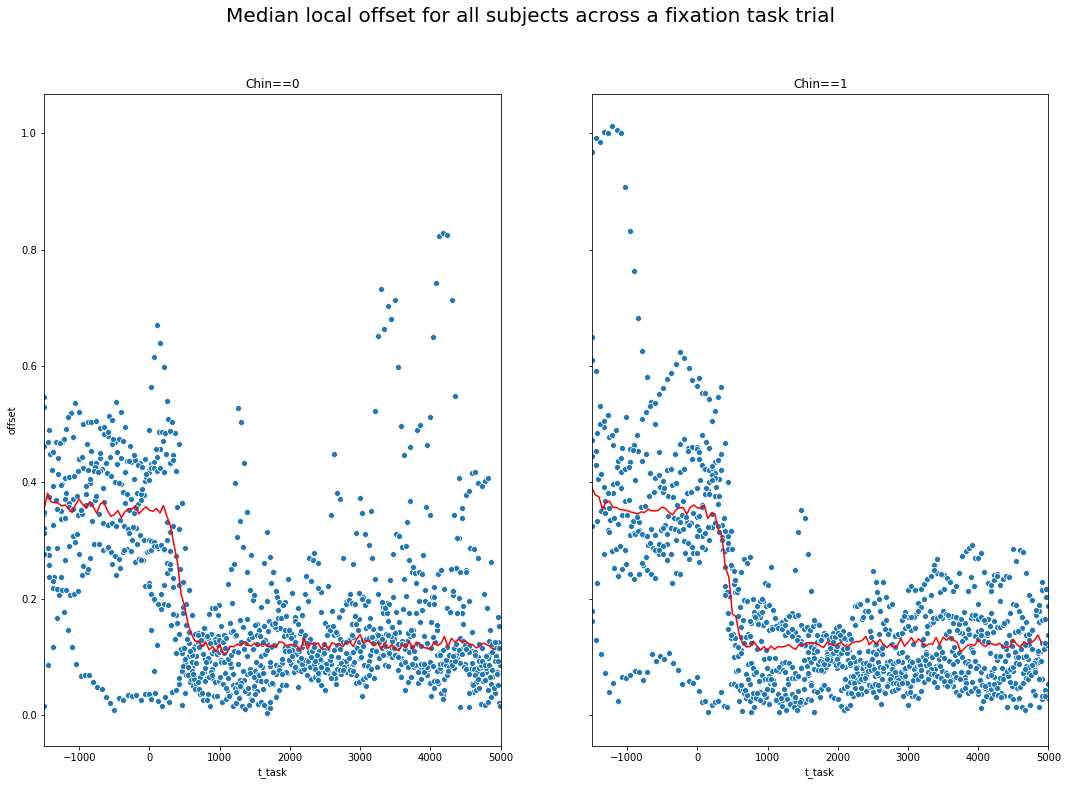

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

### Cleaning: Remove first second of fixation task 

In [63]:
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')

data_et = data_et.loc[
    ~(
        (data_et['trial_type']=='eyetracking-fix-object') &
        (data_et['trial_duration']==5000) &
        (data_et['t_task']<1000)
    ), :].reset_index(drop=True)

### data_trial_fix & data_et_fix

In [64]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000),     :
]

data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
]

### Aggregate on trial level

In [65]:
def merge_offset_by_index(data, data_et):
    if 'offset' in data.columns: 
        data = data.drop(columns=['offset'])
    grouped = data_et.groupby(['run_id', 'trial_index'])['offset'].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_offset_by_index(data_trial, data_et)

### Aggregate on subject-level 

In [66]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')

def separate_outcomes_chin_condition(data, large_data, varName):
    var_chin_0 = varName + '_chin_0' 
    var_chin_1 = varName + '_chin_1' 
    
    if var_chin_0 in data.columns: data = data.drop(columns=[var_chin_0])
    if var_chin_1 in data.columns: data = data.drop(columns=[var_chin_1])
        
    grouped = large_data \
        .groupby(['run_id', 'chin'])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns='chin', values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_chin_0, 1.0: var_chin_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_chin_0, var_chin_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_chin_condition(data_subject, data_trial_fix, 'offset')
data_subject.loc[:, ['offset', 'offset_chin_0', 'offset_chin_1']].describe()

KeyError: 'Column not found: offset'

## Precision

### Distance from AVG on et-level

In [ ]:
def merge_xy_means(data):    
    if 'x_mean' in data.columns: data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: data = data.drop(columns=['y_mean'])

    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG(data):
    data = merge_xy_means(data)
    distanceFromAVG = euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean'])
    return(distanceFromAVG)    

data_et.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et), 2)
data_et_fix.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fix), 2)

### Standard deviation of gaze points on trial-level

In [ ]:
def addPrecision(data, data_et):
    if 'precision' in data.columns: data = data.drop(columns=['precision'])
    grouped = data_et \
        .groupby(['run_id', 'trial_index'])['distanceFromAVG_square'].mean() \
        .reset_index()
    grouped['precision'] = np.sqrt(grouped['distanceFromAVG_square'])
    data = data.merge(grouped.loc[:, ['run_id', 'trial_index', 'precision']], 
                      on=['run_id', 'trial_index'], 
                      how='left')
    return(data)

data_trial = addPrecision(data_trial, data_et)
data_trial_fix = addPrecision(data_trial, data_et_fix)

### Aggregate on subject-level 

In [ ]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_chin_condition(data_subject,  data_trial_fix, 'precision')
data_subject.loc[:, ['precision', 'precision_chin_0', 'precision_chin_1']].describe()

# Gaze predictions

## For each position

In [ ]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix['x']
y = data_et_fix['y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Smoothing with  $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plot/fix_heatmap.png')

# Offset & precision

## Chin-rest conditions

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

In [ ]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

In [ ]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

### ChinFirst

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

# Visual Aid

In [ ]:
for col in ['glasses', 'sight']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

In [ ]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 1, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
data_subject['glasses_binary'].unique()

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

### Fixation dot positions

In [ ]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

## Calibration

In [ ]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial.loc[data_trial['trial_type']=='eyetracking-calibration', :]

### offset

In [ ]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

### Precision

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## categorical confounders

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='offset', data=data_subject)

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='precision', data=data_subject)

# Correlation Plot

In [ ]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

In [ ]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [ ]:
data_plot[correlation_columns].rcorr()

In [ ]:
data_plot[correlation_columns].rcorr(upper='n')

# MLA Model

In [ ]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = md.fit()
print(model_fit.summary())

# Export

In [ ]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [ ]:
print('Success! Script ran through')